In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import joblib

from data_preprocessing import pipeline, filter_unnecessary_columns
from feature_preprocessing import pipeline2

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

### 데이터 전처리

In [11]:
# 로우 데이터 불러오기
file_path = "./storage/raw_data/병합_청약매물_목록_정보_픽스2.csv"
df = pd.read_csv(file_path)
df2 = pd.read_csv("./storage/raw_data/기준금리표.csv")

# 데이터 전처리
preprocessing_pipeline = pipeline(type='train')
df = preprocessing_pipeline.transform(df)

df = df.merge(df2, left_on='모집공고일', right_on='변경일자', how='left').drop(columns=['변경일자'])

# 학습할 모델별로 드랍할 칼럼 정의
# - 최고당첨가점: 공급지역코드, 거래금액(만원), 공급세대수
# 최저당첨가점: 공급지역코드, 거래금액(만원), 공급세대수
# 시세차익: 공급지역코드, 공급세대수

# #  -----------------------------최고, 최저당점가점용-----------------------------------
# df['시세차익'] = df['전용면적'] * df['전용면적당 시세차익']
# df.drop(columns=['전용면적', '전용면적당 시세차익', '공급금액(최고가 기준)'], inplace=True)
# # 최고, 최저당점가점용
# df.drop(['공급지역코드', '거래금액(만원)', '공급세대수'], axis=1, inplace=True)


#  -----------------------------시세차익용-----------------------------------
# 시세차익 할 때 feature에서 거래금액(만원) 이부분 스케일링 해주기
df['시세차익'] = df['전용면적'] * df['전용면적당 시세차익']
df.drop(columns=['전용면적', '전용면적당 시세차익', '공급금액(최고가 기준)'], inplace=True)
df.drop(['공급지역코드', '공급세대수', '모집공고일'], axis=1, inplace=True)


# 파일 저장
file_version = "250321-시세차익-금리추가"
output_file = f"./storage/train_data/train-{file_version}.csv"
df.to_csv(output_file, index=False, encoding='cp949')

C:\Users\user\AppData\Local\Temp\ipykernel_24792\2936308845.py:3: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
c:\Users\user\mid_project\src\data_preprocessing.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['최고당첨가점'].fillna(0, inplace=True)
c:\Users\user\mid_project\src\data_preprocessing.py:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavi

### 모델 학습 및 평가

In [3]:
# 전처리된 데이터 가져오기

file_version = "250321-시세차익-금리추가"
file_path = f"./storage/train_data/train-{file_version}.csv"
df = pd.read_csv(file_path, encoding='cp949')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866 entries, 0 to 1865
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   공급규모          1866 non-null   int64  
 1   투기과열지구        1866 non-null   object 
 2   조정대상지역        1866 non-null   object 
 3   분양가상한제        1866 non-null   object 
 4   정비사업          1866 non-null   object 
 5   공공주택지구        1866 non-null   object 
 6   대규모택지개발지구     1866 non-null   object 
 7   수도권내민영공공주택지구  1866 non-null   object 
 8   순위            1866 non-null   object 
 9   거주지역          1866 non-null   object 
 10  접수건수          1866 non-null   float64
 11  경쟁률           1866 non-null   float64
 12  최저당첨가점        1866 non-null   float64
 13  토픽 1          1866 non-null   float64
 14  토픽 2          1866 non-null   float64
 15  토픽 3          1866 non-null   float64
 16  토픽 4          1866 non-null   float64
 17  토픽 5          1866 non-null   float64
 18  토픽 6          1866 non-null 

In [3]:
X = df.drop(columns=["시세차익"])
Y = df["시세차익"]

X_train, X_test, y_train, y_test = train_test_split(
    X,  # 타겟
    Y,  
    test_size=0.2,
    random_state=42
)

In [4]:
Y.describe()

count    9.366000e+03
mean     6.208246e+08
std      3.754623e+08
min      1.585877e+08
25%      3.961249e+08
50%      5.169279e+08
75%      7.499358e+08
max      5.199081e+09
Name: 시세차익, dtype: float64

In [5]:
feature_pipeline = pipeline2()

# 학습 데이터(X_train)에 fit
feature_pipeline.fit(X_train)

# 학습 데이터(X_train)를 변환
X_train_transformed = feature_pipeline.transform(X_train)

# 테스트 데이터(X_test)를 변환
X_test_transformed = feature_pipeline.transform(X_test)

Index(['공급규모', '투기과열지구', '조정대상지역', '분양가상한제', '정비사업', '공공주택지구', '대규모택지개발지구',
       '수도권내민영공공주택지구', '순위', '거주지역', '접수건수', '경쟁률', '토픽 1', '토픽 2', '토픽 3',
       '토픽 4', '토픽 5', '토픽 6', '토픽 7', '법정동코드', '거래금액(만원)', '기준금리'],
      dtype='object')
Index(['공급규모', '접수건수', '경쟁률', '토픽 1', '토픽 2', '토픽 3', '토픽 4', '토픽 5', '토픽 6',
       '토픽 7', '법정동코드', '거래금액(만원)', '기준금리', '투기과열지구_N', '투기과열지구_Y', '조정대상지역_N',
       '조정대상지역_Y', '분양가상한제_N', '분양가상한제_Y', '정비사업_N', '정비사업_Y', '공공주택지구_N',
       '공공주택지구_Y', '대규모택지개발지구_N', '대규모택지개발지구_Y', '거주지역_기타경기', '거주지역_기타지역',
       '거주지역_해당지역', '수도권내민영공공주택지구_N', '수도권내민영공공주택지구_Y', '순위_1순위', '순위_2순위'],
      dtype='object')
Index(['공급규모', '투기과열지구', '조정대상지역', '분양가상한제', '정비사업', '공공주택지구', '대규모택지개발지구',
       '수도권내민영공공주택지구', '순위', '거주지역', '접수건수', '경쟁률', '토픽 1', '토픽 2', '토픽 3',
       '토픽 4', '토픽 5', '토픽 6', '토픽 7', '법정동코드', '거래금액(만원)', '기준금리'],
      dtype='object')
Index(['공급규모', '접수건수', '경쟁률', '토픽 1', '토픽 2', '토픽 3', '토픽 4', '토픽 5', '토픽 6',
       '토픽 7', '법정동코드', '거래금액

c:\Users\user\anaconda3\envs\project-env\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\project-env\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [6]:
# shap test data 저장

X_test_transformed.to_csv('./storage/shap_test_data/gain_rf_X_test_transformed.csv', index=False)

In [7]:
# 피쳐 파이프라인 저장 

version = 'gain_rf_0.0.1'
joblib.dump(feature_pipeline, f"./storage/trained_pipeline/pipeline_{version}.pkl")

['./storage/trained_pipeline/pipeline_gain_rf_0.0.1.pkl']

### 학습

### LGB

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 7492, number of used features: 32
[LightGBM] [Info] Start training from score 620359760.213561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

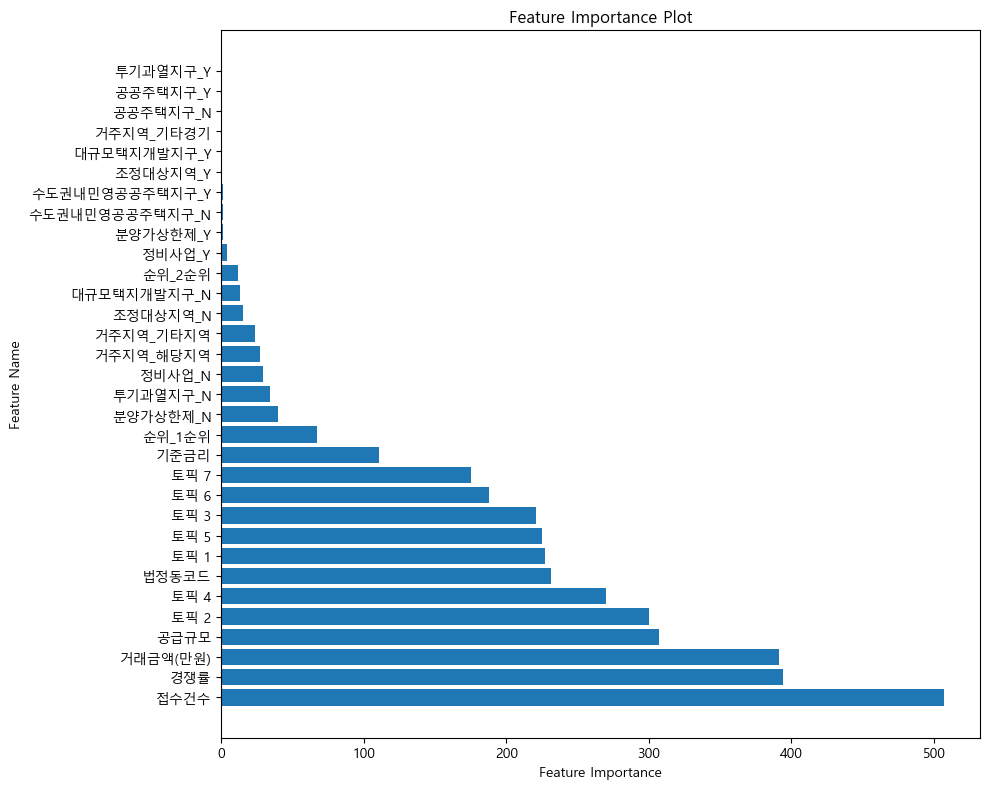

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

# LightGBM 모델 생성 및 학습
lgb_model = lgb.LGBMRegressor(
    max_depth=8, 
    num_leaves=119, 
    min_data_in_leaf=47, 
    subsample=0.7, 
    colsample_bytree=0.9, 
    learning_rate=0.1, 
    n_estimators=100
)

lgb_model.fit(X_train_transformed, y_train)

y_pred_lgb = lgb_model.predict(X_test_transformed)

# RMSE와 R^2 계산 함수
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_lgb, r2_lgb = evaluate_model(y_test, y_pred_lgb)
print(f"LightGBM - RMSE: {rmse_lgb}, R^2: {r2_lgb}")

# Feature Importance 평균 계산 및 출력
# LightGBM 모델의 feature_importances_ 속성을 사용
feature_importances = lgb_model.feature_importances_

# Feature Importance 시각화
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(X_train_transformed.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance Plot")
plt.tight_layout()  # 레이아웃 조정
plt.show()


### XGB

In [9]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# XGBoost 모델 생성
xgb_model = xgb.XGBRegressor()

xgb_param_grid = {
    'max_depth': np.arange(3, 9),  
    'min_child_weight': np.arange(1, 5),  
    'subsample': np.linspace(0.5, 1.0, 6),  # subsample의 범위를 0.5에서 1.0 사이로 설정
    'eta': np.logspace(-4, -1, 10),  
    'n_estimators': np.arange(50, 200, 50)  
}

# 랜덤 서치 설정
xgb_random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=xgb_param_grid, 
    cv=5, 
    n_iter=50
)

# 모델 학습
xgb_random_search.fit(X_train_transformed, y_train)

# 베스트 파라미터 출력
print("베스트 파라미터:")
print(xgb_random_search.best_params_)

# 테스트 데이터에서 예측 수행
y_pred = xgb_random_search.best_estimator_.predict(X_test_transformed)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R² 계산
r2 = r2_score(y_test, y_pred)

# 결과 출력
print(f"XGBoost - RMSE: {rmse:.4f}, R²: {r2:.4f}")


베스트 파라미터:
{'subsample': np.float64(0.9), 'n_estimators': np.int64(100), 'min_child_weight': np.int64(4), 'max_depth': np.int64(6), 'eta': np.float64(0.1)}
XGBoost - RMSE: 206557725.9617, R²: 0.7711


XGBoost - RMSE: 206095794.67164725, R^2: 0.772163197704471


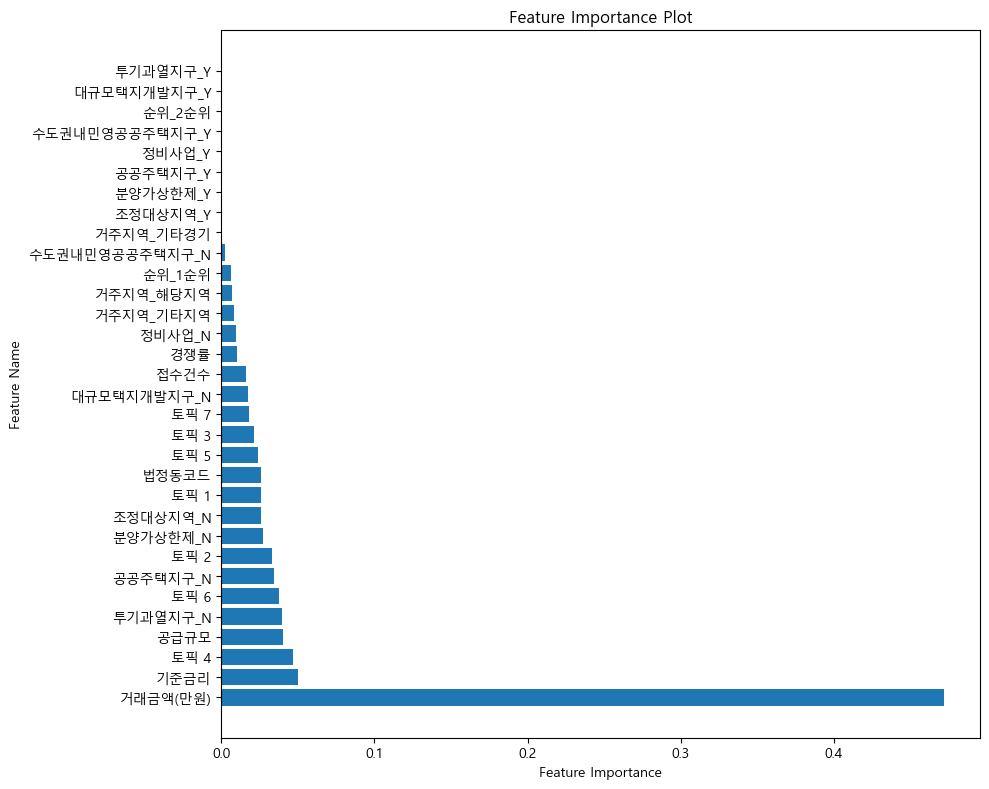

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost 모델 생성 및 학습
xgb_model = xgb.XGBRegressor(
    max_depth=6, 
    min_child_weight=4, 
    subsample=0.9, 
    eta=0.1, 
    n_estimators=100
)

xgb_model.fit(X_train_transformed, y_train)

y_pred_xgb = xgb_model.predict(X_test_transformed)

# RMSE와 R^2 계산 함수
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb)
print(f"XGBoost - RMSE: {rmse_xgb}, R^2: {r2_xgb}")

# Feature Importance 평균 계산 및 출력
# XGBoost 모델의 feature_importances_ 속성을 사용
feature_importances = xgb_model.feature_importances_

# Feature Importance 시각화
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(X_train_transformed.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance Plot")
plt.tight_layout()  # 레이아웃 조정
plt.show()


### RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 랜덤 포레스트 회귀 모델 생성
rf_model = RandomForestRegressor()

# 하이퍼파라미터 범위 설정
rf_param_grid = {
    'n_estimators': np.arange(800, 1100, 100), 
    'max_depth': np.arange(10, 60, 10), 
    'max_features': np.arange(6, 17, 2),  
    'min_samples_leaf': np.arange(8, 19, 2),  
    'min_samples_split': np.arange(8, 21, 2) 
}

# 랜덤 서치 설정
rf_random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=rf_param_grid, 
    cv=5, 
    n_iter=100
)

# 모델 학습
rf_random_search.fit(X_train_transformed, y_train)

# 베스트 파라미터 출력
print("베스트 파라미터:")
print(rf_random_search.best_params_)

# 테스트 데이터에서 예측 수행
y_pred = rf_random_search.best_estimator_.predict(X_test_transformed)
0
# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R² 계산
r2 = r2_score(y_test, y_pred)

# 결과 출력
print(f"랜덤 포레스트 - RMSE: {rmse:.4f}, R²: {r2:.4f}")


베스트 파라미터:
{'n_estimators': np.int64(1000), 'min_samples_split': np.int64(12), 'min_samples_leaf': np.int64(10), 'max_features': np.int64(16), 'max_depth': np.int64(30)}
랜덤 포레스트 - RMSE: 214569560.9500, R²: 0.7530


Random Forest - RMSE: 215172506.1784876, R^2: 0.7516528544163371


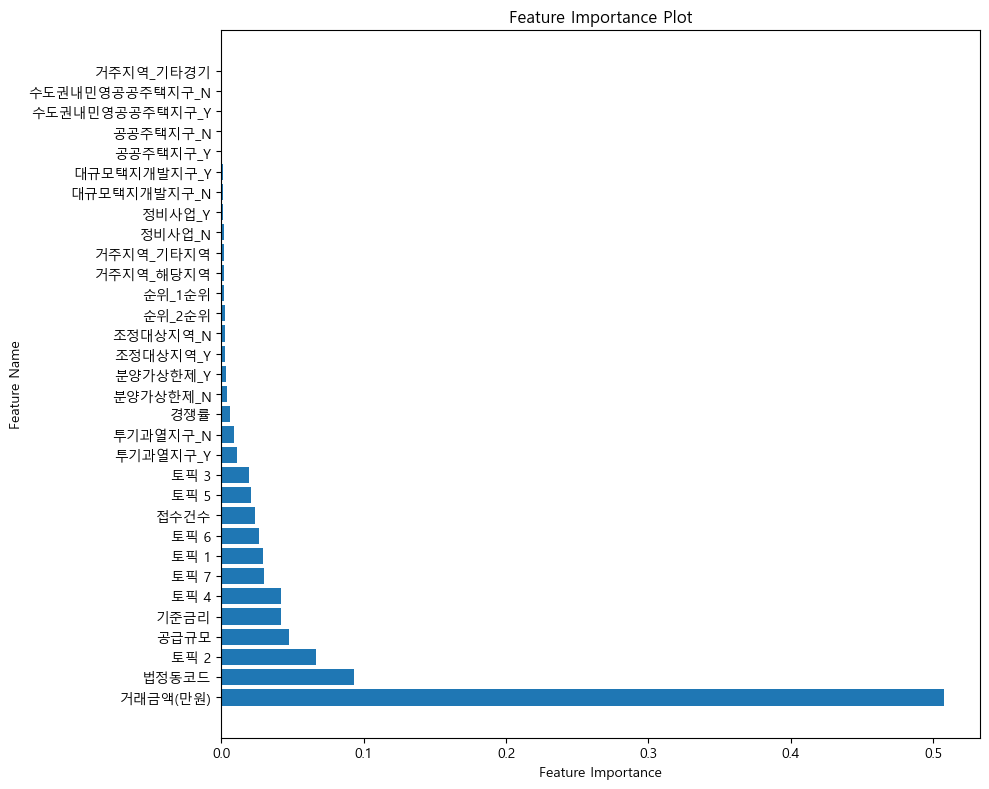

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# 랜덤 포레스트 회귀 모델 생성 및 학습
rf_model = RandomForestRegressor(
    max_depth=30, 
    max_features=16, 
    min_samples_leaf=10,
    min_samples_split=12, 
    n_estimators=1000
)

rf_model.fit(X_train_transformed, y_train)

y_pred_rf = rf_model.predict(X_test_transformed)

# RMSE와 R^2 계산 함수
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
print(f"Random Forest - RMSE: {rmse_rf}, R^2: {r2_rf}")

# Feature Importance 평균 계산 및 출력
# 랜덤 포레스트 모델의 feature_importances_ 속성을 사용
feature_importances = rf_model.feature_importances_

# Feature Importance 시각화
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(X_train_transformed.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance Plot")
plt.tight_layout()  # 레이아웃 조정
plt.show()

### 모델 저장 

In [9]:
# 모델 저장 및 로드

version = 'gain_rf_0.0.1'

# 모델 저장
joblib.dump(rf_model, f"./storage/trained_model/model_{version}.pkl")

['./storage/trained_model/model_gain_rf_0.0.1.pkl']

In [8]:
# 모델 로드
loaded_model = joblib.load("./storage/trained_model/model_0.0.1.pkl")

# 예측
# X_test = np.array([[1, 2]])
# prediction = loaded_model.predict(X_test)
# print("Prediction:", prediction)